Objective: Build a machine learning model that evaluates a person's demographic and works status to predict a need for extra mental health care.

Created using help from:
    Chat GPT
    https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir('/home/643aa895-acfe-4a55-9f84-aff3b9a97360/HealthStudy')

surveyData = pd.read_csv('HealthSurvey.csv')
    #This data came from: https://www.kaggle.com/datasets/osmi/mental-health-in-tech-survey/

surveyData.head(5)



,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [160]:
# First, let's describe some of the data to get a feel for it

minAge = surveyData.Age.min()
maxAge = surveyData.Age.max()
avgAge = int(surveyData.Age.mean())

print(f'In this study, participants averaged {avgAge} years old, with a range of {minAge} to {maxAge} years old')

In this study, participants averaged 79428148 years old, with a range of -1726 to 99999999999 years old


There are definitely some issues with the data. For age, I'm going to set any age above 120 or below 18 to 'NaN'

In [162]:
surveyData.Age = np.where((surveyData.Age > 120) | (surveyData.Age < 18), np.nan, surveyData.Age)
        # np.where(condition, x, y): This function is used to replace values where the condition is True with x and where the condition is False with y.


In [163]:
# Print average, max, and min age

minAge = surveyData.Age.min()
maxAge = surveyData.Age.max()
avgAge = int(surveyData.Age.mean())

print(f'In this study, participants averaged {avgAge} years old, with a range of {minAge} to {maxAge} years old')



In this study, participants averaged 32 years old, with a range of 18.0 to 72.0 years old


In [164]:
# Initial look at gender data

# surveyData.Gender.head(50)
# surveyData.Gender.describe()
# surveyData.Gender.unique()

# It looks like lots of variation due to typing input
    # I want to make male, Male, Cis Male, M, etc all say "Male," and same for female
    # The code below should group most of the "male" and "female" entries together, although it doesn't get all

surveyData.Gender = np.where((surveyData.Gender == 'male') | (surveyData.Gender == 'M') | (surveyData.Gender == 'Cis Male') | (surveyData.Gender == 'm'), 'Male', surveyData.Gender)
surveyData.Gender = np.where((surveyData.Gender == 'female') | (surveyData.Gender == 'F') | (surveyData.Gender == 'Cis Female') | (surveyData.Gender == 'f'), 'Female', surveyData.Gender)

In [165]:
# Calculate and print the number of male, female, and other genders within the study

uniqueGenders = surveyData.Gender.value_counts()
# print(uniqueGenders)
maleCount = uniqueGenders.Male
femaleCount = uniqueGenders.Female
otherCount = sum(uniqueGenders) - maleCount - femaleCount
print(f"Study includes {maleCount} males, {femaleCount} females, and {otherCount} other")


Study includes 973 males, 237 females, and 49 other


In [166]:
# Mental Health Evaluation
# The most important metric for mental health evaluation is probably the "Treatment" data:
        # treatment: Have you sought treatment for a mental health condition?
    
# surveyData.treatment.head()
# surveyData.treatment.unique()

# This data must have come from a yes/no checkbox, so the data is clean with only Yes or No.



In [167]:
# Before getting complex, let's explore a simple correlation between age and risk for needing mental health help
# Scatter Plot: age vs. likelihood of having sought mental health help

# Group the data into 5 year age groups, starting with 18
ageIdx = 18
while ageIdx < maxAge:
    age5 = ageIdx + 5
    ageGroups[ageIdx] = surveyData[(surveyData['Age'] >= ageIdx) & (surveyData['Age'] < age5)][['Age', 'treatment']]
    ageIdx += 5
    

In [168]:
ageIdx = 18
ageGroups = {}  # create an empty dictionary to store age groups

# Group the data into age brackets: 18-22, 23-28, etc.
while ageIdx < maxAge:
    age5 = ageIdx + 5
    ageGroups[ageIdx] = surveyData[(surveyData['Age'] >= ageIdx) & (surveyData['Age'] < age5)][['Age', 'treatment']]
    ageIdx += 5
    
yesCount = {}
noCount = {}
treatmentRatio = {}
countIdx = 0

for age, df in ageGroups.items():
    print(f"Age Group: {age} to {age + 4}")
    yesNoCount = df.treatment.value_counts() 
    
    yesCount[countIdx] = yesNoCount.get('Yes', 0) # Using .get will return a zero if there are no Yes or No's to avoid errors below
    noCount[countIdx] = yesNoCount.get('No', 0)

    # Treatment ratio is the percentage of study participants who have sought mental health treatment
    treatmentRatio[countIdx] = yesCount[countIdx]/(yesCount[countIdx] + noCount[countIdx])
    treatmentRatio[countIdx] *= 100 #Convert to a percentage

    print(f'   Group had {yesCount[countIdx]} seek treatment ({treatmentRatio[countIdx]:.1f}%), {noCount[countIdx]} not seek treatment')
    countIdx += 1


Age Group: 18 to 22
   Group had 28 seek treatment (47.5%), 31 not seek treatment
Age Group: 23 to 27
   Group had 142 seek treatment (46.7%), 162 not seek treatment
Age Group: 28 to 32
   Group had 177 seek treatment (48.5%), 188 not seek treatment
Age Group: 33 to 37
   Group had 139 seek treatment (51.5%), 131 not seek treatment
Age Group: 38 to 42
   Group had 85 seek treatment (58.2%), 61 not seek treatment
Age Group: 43 to 47
   Group had 38 seek treatment (58.5%), 27 not seek treatment
Age Group: 48 to 52
   Group had 7 seek treatment (33.3%), 14 not seek treatment
Age Group: 53 to 57
   Group had 12 seek treatment (85.7%), 2 not seek treatment
Age Group: 58 to 62
   Group had 3 seek treatment (60.0%), 2 not seek treatment
Age Group: 63 to 67
   Group had 0 seek treatment (0.0%), 1 not seek treatment
Age Group: 68 to 72
   Group had 1 seek treatment (100.0%), 0 not seek treatment


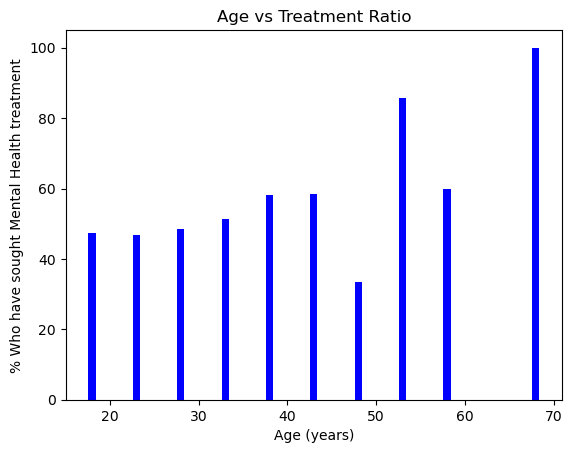

In [184]:
# Now plot the age vs ratio of those who sought treatment

# Create lists for age and treatmentRatio
ages = list(ageGroups.keys())
ratios = [treatmentRatio[idx] for idx in range(len(ageGroups))]

# Plotting
plt.bar(ages, ratios, color='blue')
plt.xlabel('Age (years)')
plt.ylabel('% Who have sought Mental Health treatment')
plt.title('Age vs Treatment Ratio')
plt.show()
   

Not really sure if there's much to conclude from this plot (it makes sense intuitively that the older a person is, the more likely they might have sought mental health treatment), but it is a good exercise to get a feel for some of the data.

In [210]:
# Now, a list of how complete all the data should be generated before continuing.

missingData = {}

for header in surveyData.columns:
    if header != 'comments': #I'm sure there's great information in the comments section, but that will be for more careful analysis later
        print(header)
        uniqueValues = surveyData[header].unique()
        print(uniqueValues)
        print('-' * 20)
        # if contains(surveyData[header].unique(),'na'):
        #     print('na here!')
        if any('na' in str(value).lower() for value in uniqueValues):
            print(f'Column "{header}" contains "na"')


Timestamp
['2014-08-27 11:29:31' '2014-08-27 11:29:37' '2014-08-27 11:29:44' ...
 '2015-11-07 12:36:58' '2015-11-30 21:25:06' '2016-02-01 23:04:31']
--------------------
Age
[37. 44. 32. 31. 33. 35. 39. 42. 23. 29. 36. 27. 46. 41. 34. 30. 40. 38.
 50. 24. 18. 28. 26. 22. 19. 25. 45. 21. nan 43. 56. 60. 54. 55. 48. 20.
 57. 58. 47. 62. 51. 65. 49. 53. 61. 72.]
--------------------
Column "Age" contains "na"
Gender
['Female' 'Male' 'Male-ish' 'maile' 'Trans-female' 'something kinda male?'
 'Woman' 'Mal' 'Male (CIS)' 'queer/she/they' 'non-binary' 'Femake' 'woman'
 'Make' 'Nah' 'All' 'Enby' 'fluid' 'Genderqueer' 'Female ' 'Androgyne'
 'Agender' 'cis-female/femme' 'Guy (-ish) ^_^' 'male leaning androgynous'
 'Male ' 'Man' 'Trans woman' 'msle' 'Neuter' 'Female (trans)' 'queer'
 'Female (cis)' 'Mail' 'cis male' 'A little about you' 'Malr' 'p' 'femail'
 'Cis Man' 'ostensibly male, unsure what that really means']
--------------------
Column "Gender" contains "na"
Country
['United States' 'Canad